# Basic Approach for Trace Clustering


## Kmeans + One Hot Encoding

Requirements:
- ~~implement basic approach (one-hot-enconding + kmeans)~~
- ~~hyperparameter experiments (grid-search)~~
- ~~interpretation of clusters (one municipal? etc.)~~
- ~~Notebook nicely presenting the clustering results for different hyperparameters~~

In [1]:
from practical.ProcessMining.group1.shared import utils
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

BASE = utils.SAMPLES_PATH
real_path = BASE / "DomesticDeclarations_cleansed.csv"
event_log = utils.import_csv(BASE / "DomesticDeclarations_cleansed.csv")

In [2]:
# One-hot encode the event log
one_hot_encoder = OneHotEncoder(sparse_output=False)
event_log_encoded = one_hot_encoder.fit_transform(event_log[["concept:name"]])

# Sample a subset of the data for faster computation
sample_indices = np.random.choice(event_log_encoded.shape[0], size=1000, replace=False)
event_log_sampled = event_log_encoded[sample_indices]

# Apply KMeans clustering with hyperparameter tuning
param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': [10, 15, 20],
    'max_iter': [300, 400, 500],
}

def evaluate_model(params, log):
    k_means = KMeans(**params, random_state=42)
    cluster_labels = k_means.fit_predict(log)
    score = silhouette_score(log, cluster_labels)
    return score, params
        
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(params, event_log_sampled) for params in ParameterGrid(param_grid))

best_score, best_params = max(results, key=lambda x: x[0])

print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")

Best Score: 0.990125
Best Params: {'init': 'random', 'max_iter': 300, 'n_clusters': 10, 'n_init': 10}


## Observations while implementation

Improvement Steps:
1. pure silhouette score calculation was too time consuming in combination with parameter tuning
2. To improve, used sample logs of actual eventlog and parallelized execution

Best score range: 
- 0.98 - 0.99

Best params: 
- 'init': 'k-means++'
- 'max_iter': 300
- 'n_clusters': 10

Mostly best params
- 'n_init': 10}

Explanation:
- n_clusters: silhouette score calculates cluster affiliation, the more clusters are used, the better silhouette scores can be expected => overfitting problem, the more clusters, the better the score while cluster <= eventlog-unique-activities
- max_iter: probably for sample set size, already after 300 iterations, no more changes
- init: trivial, that k-means++ performance in average better than random

## Apply best parameters to original Event Log

Next, using best parameters found for sample log to cluster the real log and add it as feature to each row of the eventlog

In [3]:
k_means = KMeans(**best_params, random_state=42)
event_log['cluster'] = cluster_labels = k_means.fit_predict(event_log_encoded)
# score = silhouette_score(event_log_encoded, cluster_labels)

# Split the event log into cluster sublogs
cluster_sublogs = {}
for cluster_label in event_log['cluster'].unique():
    cluster_sublogs[cluster_label] = event_log[event_log['cluster'] == cluster_label]

Finally split the modified log by cluster label and save each sublog to a csv file, so that each one can be handled as standalone eventlog

In [4]:
import os

base_dir = "base_approach"
os.makedirs(base_dir, exist_ok=True)

cluster_sublogs = {k: cluster_sublogs[k] for k in sorted(cluster_sublogs)}
for cluster_label, df in cluster_sublogs.items():
    file_path = os.path.join(base_dir, f"cluster_{cluster_label}.csv")
    df.to_csv(file_path, index=False)

print(f"Clusters exported to /base_approach")

Clusters exported to /base_approach


## Visualization of Sublogs

To visualize our result, we use pm4py alpha miner and own vizualizer implementation to visualize created sub models

==== Cluster  0 ====


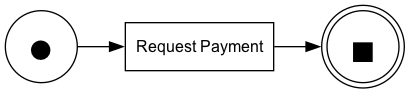

==== Cluster  1 ====


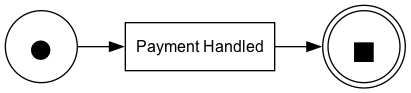

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

==== Cluster  2 ====


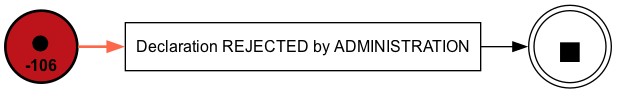

replaying log with TBR, completed traces ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/24 [00:00<?, ?it/s]

==== Cluster  3 ====


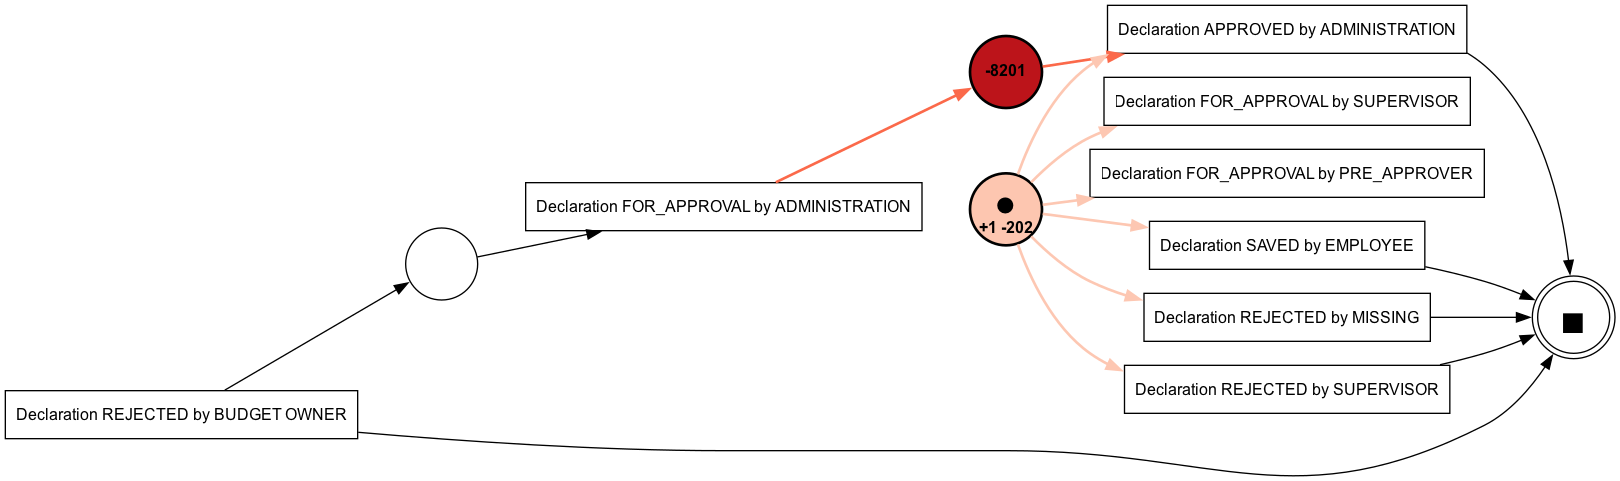

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

==== Cluster  4 ====


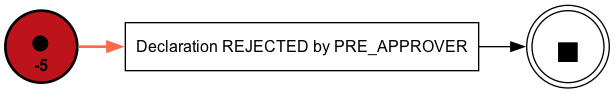

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

==== Cluster  5 ====


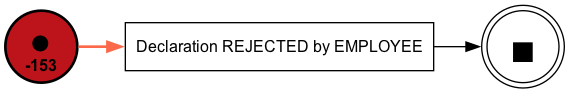

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

==== Cluster  6 ====


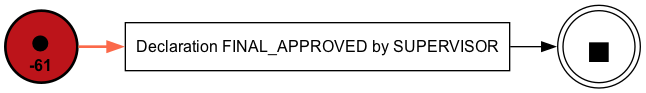

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

==== Cluster  7 ====


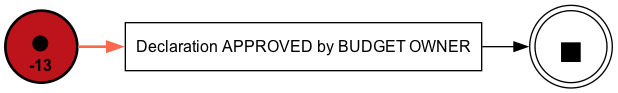

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

==== Cluster  8 ====


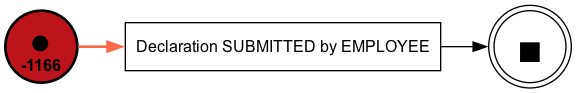

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

==== Cluster  9 ====


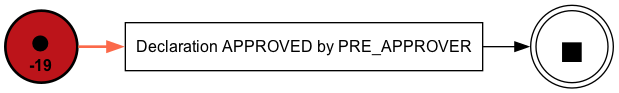

In [5]:
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.task4.tokenreplay import TokenReplay
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.objects.conversion.log import converter as log_converter

for cluster_label, df in cluster_sublogs.items():   
    event_log = log_converter.to_event_log.apply(df)

    # Alpha Miner
    alpha_net, alpha_initial_marking, alpha_final_marking = alpha_miner.apply(event_log)

    alpha_token_replay = TokenReplay(event_log, alpha_net, alpha_initial_marking, alpha_final_marking, "Alpha Miner")

    alpha_token_replay.run()  # alpha_token_replay.shuffle_activities()
    tokens = alpha_token_replay.get_unconformity_tokens()

    vizard = Visualizer()
    graph = vizard.build_petri_net(alpha_net, alpha_initial_marking, alpha_final_marking, tokens)
    print("==== Cluster ", cluster_label, "====")
    vizard.display(graph)

## Observation
Kmeans clustering (of this) eventlog results into
- clusters containing exact one activity
- an "everything else" cluster

While naively reasonable, these result have a pretty low information level. It may be, that for outliers for example separating an activity into its own cluster is beneficial (even so, it has similar effects as base case handling with IMi, while less precise tuning/threshold capabilities), but after showing the exact same behavior for different n_cluster, it can be assumed that this clustering technique simply lacking information gain. 

Possible explanations / improvements:
- silhouette score giving wrong incentives, lower score results could create clusters with more information gain
- the event log could be too simple, for other if single/remaining results
- one hot encoding is simply not suitable, due to ignored activity relationships

To check, if the silhouette score is benefitting worse clustering or the observed behaviour is conditional to the used event log, we:
- change the real event log
- introduce a pre validation while hyperparameter tuning.

When a kmeans cluster contains only single activity clusters and one remaining cluster, instead of calculating a silhouette score, we rate this with 0. If there should be a different clustering result, with worse silhouette score but not only containing (n_clusters - 1) * single activity clusters, this would get returned as best parameter. If that is not the case, best score would be 0, meaning all found trace clusters with kMeans and oneHotEncoding provide only trivial information gain.

In addition we also include parameters that have been dropped in first parameter tuning assumed to be less impactful anyway

In [6]:
# Alternative real log
event_log = utils.import_xes(str(BASE / "HospitalBilling.xes.gz"))

parsing log, completed traces ::   0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
# One-hot encode the event log
one_hot_encoder = OneHotEncoder(sparse_output=False)
event_log_encoded = one_hot_encoder.fit_transform(event_log[["concept:name"]])

# Sample a subset of the data for faster computation
sample_indices = np.random.choice(event_log_encoded.shape[0], size=1000, replace=False)
event_log_sampled = event_log_encoded[sample_indices]

# Apply KMeans clustering with hyperparameter tuning
param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': [10, 15, 20],
    'max_iter': [300, 400, 500],
    'tol': [1e-4, 1e-3, 1e-2],
    'algorithm': ['lloyd', 'elkan'],
    'random_state': [None, 42],
    'copy_x': [True, False],
}

# Introduced pre validation
def is_clustered_trivial(cluster_labels):
    # Count activities in each cluster
    unique, counts = np.unique(cluster_labels, return_counts=True)
    cluster_activity_counts = dict(zip(unique, counts))
    
    # Check for trivial clustering: all but one cluster have exactly one activity
    trivial_clusters = sum(1 for count in cluster_activity_counts.values() if count == 1)
    return trivial_clusters >= len(cluster_activity_counts) - 1
    

def evaluate_model(params, log):
    k_means = KMeans(**params)
    cluster_labels = k_means.fit_predict(log)
    if is_clustered_trivial:
        return 0, params
    score = silhouette_score(log, cluster_labels)
    return score, params
        
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(params, event_log_sampled) for params in ParameterGrid(param_grid))

best_score, best_params = max(results, key=lambda x: x[0])

print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")

Best Score: 0
Best Params: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'random_state': None, 'tol': 0.0001}


By these best score of 0, we can assume, that kmeans with one hot encoding is only producing trivial results with no real information gain. To make trace clustering useful during process mining, we need to apply more advanced techniques than hot encoding.